Question 1

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv.imread(r"E:\Academic\Sem 5\My Sem 5\Image Processing and Machine Vision\assignments\assignment 2\the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

# Check if the image was loaded successfully
if image is None:
    print("Failed to load the image.")
else:
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Plot the original image
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

# Define LoG (Laplacian of Gaussian) kernel
def log_kernel(sigma, size):
    if size % 2 == 0:
        size += 1
    sigma2 = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)
    tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)
    kernel = np.exp(tmp_cal)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    k_sum = np.sum(kernel)
    if k_sum != 0:
        kernel /= np.sum(kernel)
    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return kernel

# Blob detection function
def detect_blobs(image, sigma_scale, threshold):
    grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    grayscale_image = np.float32(grayscale_image)
    cv.normalize(grayscale_image, grayscale_image, 1, 0, cv.NORM_MINMAX)

    sigma0 = np.sqrt(2)
    k = np.sqrt(2)
    num_scales = sigma_scale
    sigmas = [sigma0 * np.power(k, i) for i in range(num_scales)]

    # Apply LoG kernel filtering with scaled kernel size and sigma
    image_stack = None
    for i in range(num_scales):
        size = int(2 * np.ceil(4 * sigmas[i]) + 1)
        # With Laplacian response normalization
        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
        filtered = cv.filter2D(grayscale_image, cv.CV_32F, kernel)
        filtered = pow(filtered, 2)
        if i == 0:
            image_stack = filtered
        else:
            image_stack = np.dstack((image_stack, filtered))

    # Maximum response extraction
    scale_space = None
    for i in range(num_scales):
        filtered = cv.dilate(image_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
        if i == 0:
            scale_space = filtered
        else:
            scale_space = np.dstack((scale_space, filtered))
    max_stack = np.amax(scale_space, axis=2)
    max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)
    max_stack = np.multiply((max_stack == scale_space), scale_space)

    radius_vector = None
    x_vector = None
    y_vector = None
    for i in range(num_scales):
        radius = np.sqrt(2) * sigmas[i]
        threshold = threshold
        # Filter out redundant responses
        valid = (max_stack[:, :, i] == image_stack[:, :, i]) * image_stack[:, :, i]
        valid[valid <= threshold] = 0
        (x, y) = np.nonzero(valid)
        if i == 1:
            x_vector = x
            y_vector = y
            radius_vector = np.repeat(radius, np.size(x))
        else:
            x_vector = np.concatenate((x_vector, x), axis=None)
            y_vector = np.concatenate((y_vector, y), axis=None)
            tmp_vector = np.repeat(radius, np.size(x))
            radius_vector = np.concatenate((radius_vector, tmp_vector), axis=None)

    return x_vector, y_vector, radius_vector

x_all_blobs = []
y_all_blobs = []
radii_all_blobs = []
for sigma_scale in range(2, 10):
    x_coords, y_coords, radii = detect_blobs(image, sigma_scale, 0.03)
    x_all_blobs.append(x_coords)
    y_all_blobs.append(y_coords)
    radii_all_blobs.append(radii)

x_all_blobs = np.concatenate(x_all_blobs, axis=None)
y_all_blobs = np.concatenate(y_all_blobs, axis=None)
radii_all_blobs = np.concatenate(radii_all_blobs, axis=None)

output_image = image.copy()
for i in range(int(len(x_all_blobs))):
    cv.circle(output_image, (y_all_blobs[i], x_all_blobs[i]), int(radii_all_blobs[i]), (0, 0, 255), 1)

plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Blob Detection")
plt.axis('off')
plt.show()

#getting the parameters of the largest circles
x_all_blobs = []
y_all_blobs = []
radii_all_blobs = []
for sigma_scale in range(2, 10):
    x_coords, y_coords, radii = detect_blobs(image, sigma_scale, 0.03)
    x_all_blobs.append(x_coords)
    y_all_blobs.append(y_coords)
    radii_all_blobs.append(radii)

x_all_blobs = np.concatenate(x_all_blobs, axis=None)
y_all_blobs = np.concatenate(y_all_blobs, axis=None)
radii_all_blobs = np.concatenate(radii_all_blobs, axis=None)

#displaying the above parameter values
print("x_all_blobs: ", x_all_blobs)
print("y_all_blobs: ", y_all_blobs)
print("radii_all_blobs: ", radii_all_blobs)

#getting the range of sigma values used
sigma_scale = range(2, 10)
print("sigma_scale: ", sigma_scale)



Question 02

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Number of points and parameters
num_points = 100
half_num_points = num_points // 2
circle_radius = 10
circle_center_x, circle_center_y = 2, 3  # Circle center
circle_noise = circle_radius / 16
line_noise = 1.0
line_slope, line_intercept = -1, 2

# Generate points conforming to a circle
theta_circle = np.random.uniform(0, 2 * np.pi, half_num_points)
noise_circle = circle_noise * np.random.randn(half_num_points)
x_circle = circle_center_x + (circle_radius + noise_circle) * np.cos(theta_circle)
y_circle = circle_center_y + (circle_radius + noise_circle) * np.sin(theta_circle)
circle_points = np.hstack((x_circle.reshape(half_num_points, 1), y_circle.reshape(half_num_points, 1)))

# Generate points conforming to a line
x_line = np.linspace(-12, 12, half_num_points)
y_line = line_slope * x_line + line_intercept + line_noise * np.random.randn(half_num_points)
line_points = np.hstack((x_line.reshape(half_num_points, 1), y_line.reshape(half_num_points, 1)))

# Combine circle and line points into a single dataset
combined_points = np.vstack((circle_points, line_points))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], label='Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle')

# Plot ground truth circle
circle_gt = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(circle_center_x, circle_center_y, '+', color='g')

# Plot ground truth line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='m', label='Ground truth line')

# Legend
plt.legend()


def line_ransac(points_set, dist_threshold):
    max_iters = 10000
    best_line_estimate = None
    best_inliers_indices = []

    for _ in range(max_iters):
        # Randomly select two points to define a line
        sampled_indices = np.random.choice(len(points_set), size=2, replace=False)
        sampled_points = points_set[sampled_indices]

        # Calculate the unit normal vector to the line
        x1, y1 = sampled_points[0]
        x2, y2 = sampled_points[1]
        if x1 == x2:
            continue  # Avoid division by zero
        direction_vector = np.array([y1 - y2, x2 - x1])
        unit_normal_vector = direction_vector / np.linalg.norm(direction_vector)
        d_init = np.abs(np.dot(unit_normal_vector, np.array([x1, y1])))

        # Calculate the perpendicular distance from the origin to the line
        perp_distances = [np.abs(np.dot(unit_normal_vector, np.array([x, y]))) for x, y in points_set]

        # Find inliers based on the distance threshold
        inliers_indices = [i for i, distance in enumerate(perp_distances) if np.abs(distance - d_init) < dist_threshold]

        # Update the best model if this one has more inliers
        if len(inliers_indices) > len(best_inliers_indices):
            best_line_estimate = (unit_normal_vector, d_init)
            best_inliers_indices = inliers_indices
            best_fitting_points = sampled_points

    return best_line_estimate, best_inliers_indices, best_fitting_points


def circle_equation_updated(params, points_set):
    h, k, r = params
    residuals = []
    for x, y in points_set:
        residuals.append((x - h) ** 2 + (y - k) ** 2 - r ** 2)
    return np.array(residuals)


def circle_ransac(points_set, radial_dist_threshold):
    max_iters = 10000
    best_circle_estimate = None
    best_inliers_indices = []

    for _ in range(max_iters):
        # Randomly select three points to define a circle
        sampled_indices = np.random.choice(len(points_set), size=3, replace=False)
        sampled_points = points_set[sampled_indices]

        # Calculate the center and radius of the estimated circle
        x1, y1 = sampled_points[0]
        x2, y2 = sampled_points[1]
        x3, y3 = sampled_points[2]

        # Use an optimizer to find circle parameters
        result = minimize(lambda params: np.sum(circle_equation_updated(params, sampled_points) ** 2), [0, 0, 1])

        # Optimized center coordinates and radius
        h_opt, k_opt, r_opt = result.x

        # Calculate the perpendicular distance from the origin to the circle
        radial_distances = [np.abs(np.sqrt((x - h_opt) ** 2 + (y - k_opt) ** 2) - r_opt) for x, y in points_set]

        # Find inliers based on the distance threshold
        inliers_indices = [i for i, distance in enumerate(radial_distances) if distance < radial_dist_threshold]

        # Update the best model if this one has more inliers
        if len(inliers_indices) > len(best_inliers_indices):
            best_circle_estimate = (np.array([h_opt, k_opt]), r_opt)
            best_inliers_indices = inliers_indices
            best_fitting_points = sampled_points

    return best_circle_estimate, best_inliers_indices, best_fitting_points


# Estimate the line using RANSAC
estimated_line, inliers_indices_line, best_fitting_points_line = line_ransac(combined_points, 1)

# Generate x values for plotting
x_vals = np.linspace(-15, 15, 100)

# Calculate the y values of the estimated line
slope_estimate = -estimated_line[0][0] / estimated_line[0][1]
intercept_estimate = estimated_line[1] / np.cos(np.arctan(abs(slope_estimate)))
y_vals = slope_estimate * x_vals + intercept_estimate

# Estimate the circle using RANSAC
points_for_circle = combined_points.copy()

# Remove the inliers of the line from points_for_circle
points_for_circle = np.delete(points_for_circle, inliers_indices_line, axis=0)

estimated_circle, inliers_indices_circle, best_fitting_points_circle = circle_ransac(points_for_circle, 1)

# Generate theta values for plotting the circle
theta_vals = np.linspace(0, 2 * np.pi, 100)

# Calculate x and y values for the estimated circle
x_vals_circle = estimated_circle[0][0] + estimated_circle[1] * np.cos(theta_vals)
y_vals_circle = estimated_circle[0][1] + estimated_circle[1] * np.sin(theta_vals)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the original line and circle points
ax.scatter(line_points[:, 0], line_points[:, 1], label='Original Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Original Circle')

# Plot the ground truth circle
ground_truth_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(circle_center_x, circle_center_y, '+', color='g')

# Plot the ground truth line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='m', label='Ground Truth Line')

# Scatter plot for the line inliers and best fit points of the estimated line
ax.scatter(combined_points[inliers_indices_line][:, 0], combined_points[inliers_indices_line][:, 1], color='y', label='Line Inliers')
ax.scatter(np.array(best_fitting_points_line)[:, 0], np.array(best_fitting_points_line)[:, 1], marker='x', color='r', label='Best Fit Points of Estimated Line')

# Plot the estimated line
ax.plot(x_vals, y_vals, color='r', label='Estimated Line')

# Scatter plot for the circle inliers and best fit points of the estimated circle
ax.scatter(points_for_circle[inliers_indices_circle][:, 0], points_for_circle[inliers_indices_circle][:, 1], color='pink', label='Circle Inliers')
ax.scatter(np.array(best_fitting_points_circle)[:, 0], np.array(best_fitting_points_circle)[:, 1], marker='x', color='k', label='Best Fit Points of Estimated Circle')

# Plot the estimated circle
ax.plot(x_vals_circle, y_vals_circle, color='k', label='Estimated Circle')

# Legend
plt.legend()

# Show the plot
plt.show()


Question 03

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def mouse_clicks(event, x, y, flags, params):
    global clicked_coordinates
    global clicked_count
    global first_image

    if event == cv.EVENT_LBUTTONDOWN:
        clicked_coordinates.append([x, y])
        clicked_count += 1

        first_image = cv.circle(first_image, (x, y), 2, (0, 0, 1), -1)
        cv.imshow("Custom Image", first_image)        
    
    if clicked_count == 4:
        cv.destroyAllWindows()
        cv.waitKey(1)

# Load and preprocess images
image_1 = cv.imread(r"E:\Academic\Sem 5\My Sem 5\Image Processing and Machine Vision\assignments\assignment 2\luna.jpg")

#decrease the size of the figure
image_1 = cv.resize(image_1, (0, 0), fx=0.5, fy=0.5)

image_2 = cv.imread(r"E:\Academic\Sem 5\My Sem 5\Image Processing and Machine Vision\assignments\assignment 2\download (1).png")

image_1 = image_1.astype(np.float64) / np.iinfo(image_1.dtype).max
image_2 = image_2.astype(np.float64) / np.iinfo(image_2.dtype).max

first_image = np.copy(image_1)

clicked_coordinates = []
clicked_count = 0

cv.imshow("Custom Image", image_1)
cv.setMouseCallback("Custom Image", mouse_clicks)
cv.waitKey(0)
cv.destroyAllWindows()

# Input parameters
X = np.array([[0, 0, 1], [image_2.shape[1], 0, 1], [image_2.shape[1], image_2.shape[0], 1], [0, image_2.shape[0], 1]]).T
Y = np.array([[clicked_coordinates[0][0], clicked_coordinates[0][1], 1], [clicked_coordinates[1][0], clicked_coordinates[1][1], 1], [clicked_coordinates[2][0], clicked_coordinates[2][1], 1], [clicked_coordinates[3][0], clicked_coordinates[3][1], 1]]).T
O = np.array([[0], [0], [0]])

A = []

for i in range(4):
    A.append(np.concatenate((O.T, np.expand_dims(X.T[i, :], axis=0), np.expand_dims(-1 * Y[1, i] * X.T[i, :], axis=0)), axis=1))
    A.append(np.concatenate((np.expand_dims(X.T[i, :], axis=0), O.T, np.expand_dims(-1 * Y[0, i] * X.T[i, :], axis=0)), axis=1))

A = np.array(A).squeeze().astype(np.float64)

eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
H = eigen_vectors[:, np.argmin(eigen_values)]
H = H.reshape(3, -1)

t_image_2 = cv.warpPerspective(image_2, H, (image_1.shape[1], image_1.shape[0]))

beta = 0.5
blended_img = cv.addWeighted(image_1, 1, t_image_2, beta, 0.0)
blended_img[blended_img > 1] = 1

first_image_rgb = cv.cvtColor(first_image.astype(np.float32), cv.COLOR_BGR2RGB) 
image_2_rgb = cv.cvtColor(image_2.astype(np.float32), cv.COLOR_BGR2RGB)
blended_img_rgb = cv.cvtColor(blended_img.astype(np.float32), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(40, 15))
ax[0].imshow(first_image_rgb)
ax[1].imshow(image_2_rgb)
ax[2].imshow(blended_img_rgb)

ax[0].set_title("Custom Image 1")
ax[1].set_title("Custom Image 2")
ax[2].set_title("Custom Final Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

plt.show()


Question 04

[[ 1.91699743e+00  3.67870070e-03  1.16815918e+02]
 [ 1.74391346e+00  1.30868704e+00 -2.47250671e+02]
 [ 3.43849376e-03 -6.34090607e-04  1.00000000e+00]]


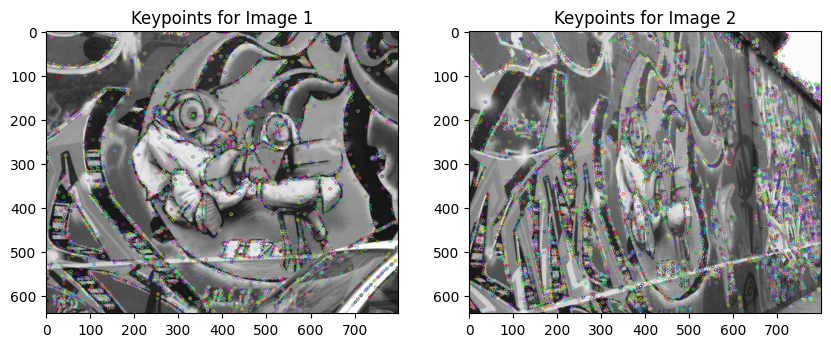

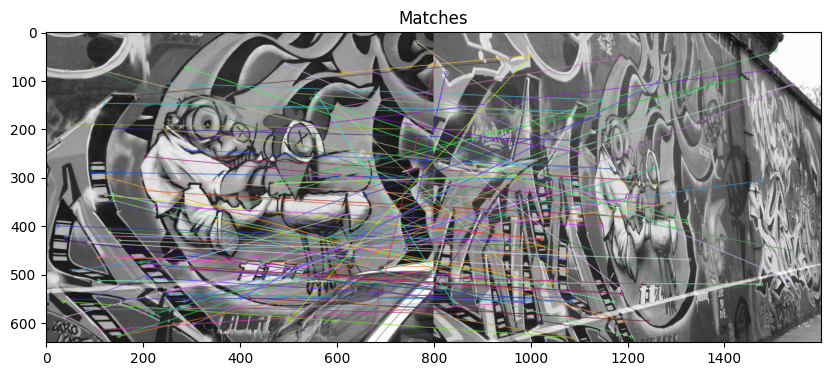

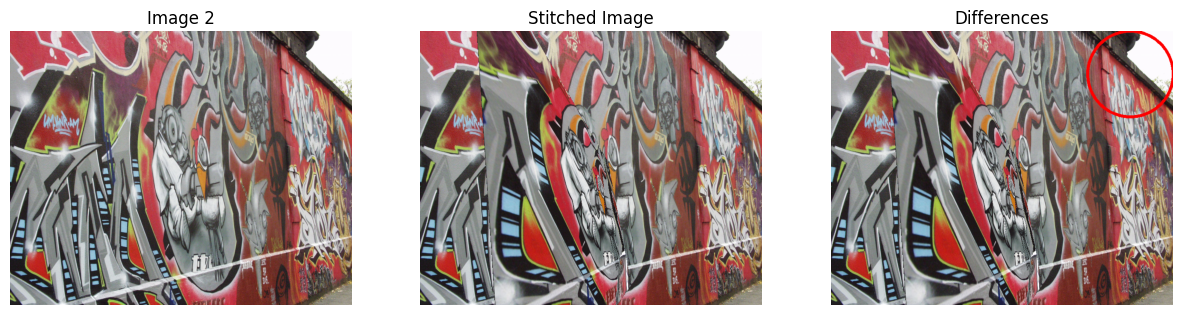

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

def load_image(file_path):
    img = cv.imread(file_path)
    assert img is not None, "Failed to load image."
    return img

def preprocess_image(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.07, edgeThreshold=20, sigma=1)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return gray, keypoints, descriptors

def draw_detected_keypoints(img, keypoints):
    return cv.drawKeypoints(img, keypoints, None)

def match_keypoints(descriptors1, descriptors2):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches, pts1, pts2 = [], [], []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])
            pts1.append(keypoints1[m.queryIdx].pt)
            pts2.append(keypoints2[m.trainIdx].pt)

    return np.array(good_matches), np.array(pts1), np.array(pts2)

def compute_homography_matrix(pts1, pts2):
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1, s2 = len(pts1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((pts1 - mean1) ** 2, axis=1))), len(pts1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((pts2 - mean2) ** 2, axis=1)))
    
    tx1, ty1, tx2, ty2 = -s1 * mean1[0], -s1 * mean1[1], -s2 * mean2[0], -s2 * mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0] * X11[0][0], X21[0][0] * X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0] * X11[0][0], X21[1][0] * X11[1][0], X21[1][0]))
    
    A = np.array(A)
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))
    
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    
    return H

def calculate_distance(p1, p2, H):
    p1 = np.array([p1[0], p1[1], 1])
    p2 = np.array([p2[0], p2[1], 1])
    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    return np.linalg.norm(p2.T - p2_estimate)

def ransac_compute_homography(pts1, pts2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((pts1, pts2))
    num_iterations = int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5) ** 4))

    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = compute_homography_matrix(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if calculate_distance(pts1_rem[i], pts2_rem[i], H) < 100]

        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)

    H = compute_homography_matrix(selected_inliers[:, 0], selected_inliers[:, 1])
    
    return H

# Load images
image1 = load_image(r"E:\Academic\Sem 5\My Sem 5\Image Processing and Machine Vision\assignments\assignment 2\img1.ppm")
image2 = load_image(r"E:\Academic\Sem 5\My Sem 5\Image Processing and Machine Vision\assignments\assignment 2\img5.ppm")

# SIFT keypoints and descriptors
image1_gray, keypoints1, descriptors1 = preprocess_image(image1)
image2_gray, keypoints2, descriptors2 = preprocess_image(image2)

# Draw keypoints
image1_keypoints = draw_detected_keypoints(image1_gray, keypoints1)
image2_keypoints = draw_detected_keypoints(image2_gray, keypoints2)

# Match keypoints
good_matches, matched_pts1, matched_pts2 = match_keypoints(descriptors1, descriptors2)

# Draw matches
matched_images = cv.drawMatchesKnn(image1_gray, keypoints1, image2_gray, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Compute homography using RANSAC
computed_homography_matrix = ransac_compute_homography(matched_pts1, matched_pts2)

# Print the computed homography matrix
print(computed_homography_matrix)

# Convert the list of tuples to a NumPy array
computed_homography_matrix = np.array(computed_homography_matrix)

# Warp image1 using the perspective transformation matrix
warped_image1 = cv.warpPerspective(image1, computed_homography_matrix, (image2.shape[1], image2.shape[0]))

# Threshold the warped image to create a binary mask
_, thresholded_image = cv.threshold(warped_image1, 10, 1, cv.THRESH_BINARY_INV)

# Multiply the binary mask with image2 to extract the common region
masked_image2 = np.multiply(thresholded_image, image2)

# Blend the thresholded image with the warped image
blended_image = cv.addWeighted(masked_image2, 1, warped_image1, 1, 0)

# Display the original images with keypoints and matches
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image1_keypoints)
plt.title('Keypoints for Image 1')
plt.subplot(122)
plt.imshow(image2_keypoints)
plt.title('Keypoints for Image 2')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(matched_images)
plt.title('Matches')
plt.show()

# Create a figure with three subplots for visualization
fig, ax = plt.subplots(1, 3, figsize=(15, 12))

# Display image2
ax[0].imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
ax[0].set_title("Image 2")
ax[0].axis("off")

# Display the stitched image
ax[1].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
ax[1].set_title("Stitched Image")
ax[1].axis("off")

# Add a circle to highlight the difference between the images
blended_image = cv.circle(blended_image, (700, 100), 100, (0, 0, 255), 5)

# Display the image with the circle
ax[2].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
ax[2].set_title("Differences")
ax[2].axis("off")

# Show the figure with the subplots
plt.show()
